# NYC Landmarks Vector Database - Processing Status Analysis

This notebook analyzes the processing status of NYC landmark records in the Pinecone vector database. It determines which landmarks have already been processed (have vectors in Pinecone) and which landmarks still need processing.

## Objectives

1. Connect to CoreDataStore API and Pinecone database
2. Fetch all available landmark IDs from the CoreDataStore API
3. Check which landmarks already have vectors in Pinecone
4. Generate statistics and visualizations of processing status
5. Export a list of unprocessed landmarks for batch processing
6. Generate a GitHub Actions workflow configuration for remaining processing

## 1. Setup & Imports

First, we'll import the necessary libraries and set up the environment.

In [1]:
# Standard libraries
import sys
import time

# Visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

# Add project directory to path
sys.path.append("..")

# Set visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Configure logging
import logging

# Import project modules
from nyc_landmarks.config.settings import settings
from nyc_landmarks.db.db_client import get_db_client
from nyc_landmarks.vectordb.pinecone_db import PineconeDB

# Set up logger
logger = logging.getLogger()
logging.basicConfig(
    level=settings.LOG_LEVEL.value,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

## 2. Connect to Databases

Next, we'll establish connections to both the CoreDataStore API and the Pinecone vector database.

In [3]:
# Initialize the database client for CoreDataStore API
db_client = get_db_client()
print("✅ Initialized CoreDataStore API client")

INFO:nyc_landmarks.db.db_client:Using CoreDataStore API client
INFO:nyc_landmarks.db.coredatastore_api:Initialized CoreDataStore API client


✅ Initialized CoreDataStore API client


In [4]:
# Initialize the Pinecone database client
try:
    # Create PineconeDB instance
    pinecone_db = PineconeDB()

    # Check if the connection was successful
    if pinecone_db.index:
        print(f"✅ Successfully connected to Pinecone index: {pinecone_db.index_name}")
        print(f"Namespace: {pinecone_db.namespace}")
        print(f"Dimensions: {pinecone_db.dimensions}")
        print(f"Metric: {pinecone_db.metric}")
    else:
        print(
            "❌ Failed to connect to Pinecone. Check your credentials and network connection."
        )
except Exception as e:
    print(f"❌ Error initializing Pinecone: {e}")

INFO:nyc_landmarks.db.db_client:Using CoreDataStore API client
INFO:nyc_landmarks.db.coredatastore_api:Initialized CoreDataStore API client
INFO:nyc_landmarks.vectordb.pinecone_db:Initialized Pinecone client
INFO:nyc_landmarks.vectordb.pinecone_db:Connected to Pinecone index: nyc-landmarks


✅ Successfully connected to Pinecone index: nyc-landmarks
Namespace: landmarks
Dimensions: 1536
Metric: cosine


In [5]:
# Get index statistics from Pinecone
try:
    stats = pinecone_db.get_index_stats()

    # Check for errors
    if "error" in stats:
        print(f"❌ Error retrieving index stats: {stats['error']}")
        # Create fallback mock stats for demonstration
        total_vector_count = 0
        namespaces = {}
    else:
        print("✅ Successfully retrieved index stats")
        total_vector_count = stats.get("total_vector_count", 0)
        namespaces = stats.get("namespaces", {})
except Exception as e:
    print(f"❌ Error retrieving index stats: {e}")
    # Create fallback mock stats for demonstration
    total_vector_count = 0
    namespaces = {}
    stats = {}

print("\n📊 Index Statistics:")
print(f"Total Vector Count: {total_vector_count:,}")
print(f"Dimension: {stats.get('dimension')}")
print(f"Index Fullness: {stats.get('index_fullness')}")

✅ Successfully retrieved index stats

📊 Index Statistics:
Total Vector Count: 16,141
Dimension: 1536
Index Fullness: 0.0


## 3. Fetch All Landmark IDs

Now we'll fetch all landmark IDs from the CoreDataStore API to determine the total universe of landmarks.

In [6]:
def fetch_all_landmark_ids(start_page=1, end_page=None, page_size=100, max_pages=500):
    """Fetch all landmark IDs from CoreDataStore API.

    Args:
        start_page: Starting page number (default: 1)
        end_page: Ending page number (default: None, fetch until no more results)
        page_size: Number of landmarks per page (default: 100)
        max_pages: Maximum number of pages to fetch (safety limit)

    Returns:
        Set of landmark IDs
    """
    all_landmark_ids = set()
    current_page = start_page
    total_pages_fetched = 0

    try:
        with tqdm(desc="Fetching landmark IDs", unit="page") as pbar:
            while True:
                # Check if we've reached the end page or max pages
                if (
                    end_page and current_page > end_page
                ) or total_pages_fetched >= max_pages:
                    break

                # Fetch landmarks for the current page
                try:
                    # Fetch API results for current page
                    landmarks = db_client.get_landmarks_page(page_size, current_page)

                except Exception as e:
                    print(f"Error fetching page {current_page}: {e}")
                    # Try to continue with next page
                    current_page += 1
                    total_pages_fetched += 1
                    pbar.update(1)
                    continue

                # If no landmarks found, we've reached the end
                if not landmarks:
                    print(f"No landmarks found on page {current_page}, ending fetch")
                    break

                # Process the landmarks
                for landmark in landmarks:
                    landmark_id = landmark.get("id", "") or landmark.get("lpNumber", "")
                    if landmark_id:
                        all_landmark_ids.add(landmark_id)

                # Update progress
                pbar.set_postfix(
                    {
                        "page": current_page,
                        "landmarks": len(landmarks),
                        "total": len(all_landmark_ids),
                    }
                )
                pbar.update(1)

                # Move to next page
                current_page += 1
                total_pages_fetched += 1

                # Small delay to avoid rate limiting
                time.sleep(0.5)
    except Exception as e:
        print(f"Error fetching landmark IDs: {e}")

    print(
        f"Completed fetching {len(all_landmark_ids)} landmark IDs from {total_pages_fetched} pages"
    )
    return all_landmark_ids


# Try to get total records from API
try:
    # Force reload the db_client module to get the latest version with the new method
    import importlib

    import nyc_landmarks.db.db_client

    importlib.reload(nyc_landmarks.db.db_client)

    # Reinitialize the database client to get the updated class definition
    from nyc_landmarks.db.db_client import get_db_client

    db_client = get_db_client()
    print("✅ Reloaded and reinitialized the CoreDataStore API client")

    # Now try to use the get_total_record_count method (should be available after reload)
    total_records = db_client.get_total_record_count()
    print(f"Total landmark records available from API: {total_records}")
except Exception as e:
    print(f"Error getting total record count: {e}")
    # Use a reasonable default based on API documentation
    total_records = 1765
    print(f"Falling back to default record count: {total_records}")

# Configure fetch parameters
page_size = 100
start_page = 1

# Calculate the required number of pages (using ceiling division)
# This ensures we get all records even if the last page is partial
total_pages = (total_records + page_size - 1) // page_size

print(
    f"Will fetch {total_records} records using {total_pages} pages with {page_size} records per page"
)

INFO:nyc_landmarks.db.db_client:Using CoreDataStore API client
INFO:nyc_landmarks.db.coredatastore_api:Initialized CoreDataStore API client


✅ Reloaded and reinitialized the CoreDataStore API client


INFO:nyc_landmarks.db.db_client:Retrieved total record count: 1765 from key: total


Total landmark records available from API: 1765
Will fetch 1765 records using 18 pages with 100 records per page


In [7]:
# Fetch all landmark IDs
start_time = time.time()
all_landmark_ids = fetch_all_landmark_ids(
    start_page=start_page, end_page=total_pages, page_size=page_size
)
elapsed_time = time.time() - start_time

print(
    f"Fetched {len(all_landmark_ids)} unique landmark IDs in {elapsed_time:.2f} seconds"
)

Fetching landmark IDs: 0page [00:00, ?page/s]

Completed fetching 1765 landmark IDs from 18 pages
Fetched 1765 unique landmark IDs in 12.21 seconds


## 4. Check Processing Status in Pinecone

Now we'll check which landmarks already have vectors in Pinecone.

In [8]:
def check_landmark_processing_status(pinecone_db, landmark_ids, batch_size=10, top_k=1):
    """Check which landmarks have vectors in Pinecone.

    Args:
        pinecone_db: PineconeDB instance
        landmark_ids: Set of landmark IDs to check
        batch_size: Number of landmarks to check in parallel batches
        top_k: Number of vectors to retrieve per landmark (1 is sufficient to check existence)

    Returns:
        processed_landmarks: Set of landmark IDs that have vectors
        unprocessed_landmarks: Set of landmark IDs that don't have vectors
    """
    # Generate a random query vector for searching
    random_vector = np.random.rand(pinecone_db.dimensions).tolist()

    processed_landmarks = set()
    unprocessed_landmarks = set()

    # Convert set to list for iteration with tqdm
    landmark_ids_list = list(landmark_ids)

    with tqdm(total=len(landmark_ids_list), desc="Checking processing status") as pbar:
        for i in range(0, len(landmark_ids_list), batch_size):
            # Get the current batch
            batch = landmark_ids_list[i : i + batch_size]

            # Check each landmark in the batch
            for landmark_id in batch:
                # Query Pinecone for vectors with this landmark_id
                filter_dict = {"landmark_id": landmark_id}
                try:
                    # We only need to know if vectors exist, so top_k=1 is sufficient
                    vectors = pinecone_db.query_vectors(
                        query_vector=random_vector, top_k=top_k, filter_dict=filter_dict
                    )

                    # If vectors found, mark as processed, otherwise unprocessed
                    if vectors:
                        processed_landmarks.add(landmark_id)
                    else:
                        unprocessed_landmarks.add(landmark_id)
                except Exception as e:
                    print(f"Error checking landmark {landmark_id}: {e}")
                    # If we can't check, assume unprocessed to be safe
                    unprocessed_landmarks.add(landmark_id)

            # Update progress
            pbar.update(len(batch))
            pbar.set_postfix(
                {
                    "processed": len(processed_landmarks),
                    "unprocessed": len(unprocessed_landmarks),
                }
            )

            # Small delay to avoid rate limiting
            time.sleep(0.2)

    return processed_landmarks, unprocessed_landmarks

In [9]:
# Check processing status for all landmarks
start_time = time.time()
processed_landmarks, unprocessed_landmarks = check_landmark_processing_status(
    pinecone_db=pinecone_db,
    landmark_ids=all_landmark_ids,
    batch_size=10,  # Adjust based on API rate limits
    top_k=1,
)
elapsed_time = time.time() - start_time

print(f"\nProcessing status check completed in {elapsed_time:.2f} seconds")
print(f"Total landmarks: {len(all_landmark_ids)}")
print(
    f"Processed landmarks: {len(processed_landmarks)} ({len(processed_landmarks)/len(all_landmark_ids)*100:.2f}%)"
)
print(
    f"Unprocessed landmarks: {len(unprocessed_landmarks)} ({len(unprocessed_landmarks)/len(all_landmark_ids)*100:.2f}%)"
)

Checking processing status:   0%|          | 0/1765 [00:00<?, ?it/s]

INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 0 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 0 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 1 matches
INFO:nyc_landmarks.vector


Processing status check completed in 143.78 seconds
Total landmarks: 1765
Processed landmarks: 1590 (90.08%)
Unprocessed landmarks: 175 (9.92%)


## 5. Analysis and Visualizations

Now we'll analyze the processing status and create visualizations.

In [10]:
# Skip DataFrame creation entirely and use Python native data structures
# Sort the landmark IDs for consistent display
landmark_ids_list = sorted(all_landmark_ids)
processed_landmarks_set = processed_landmarks
unprocessed_landmarks_set = unprocessed_landmarks

# Count the number of processed and unprocessed landmarks
total_landmarks = len(landmark_ids_list)
processed_count = len(processed_landmarks_set)
unprocessed_count = len(unprocessed_landmarks_set)

# Calculate percentages
processed_percentage = (processed_count / total_landmarks) * 100
unprocessed_percentage = (unprocessed_count / total_landmarks) * 100

# Display the statistics
print("Processing Statistics:")
print(f"Total landmarks: {total_landmarks}")
print(f"Processed landmarks: {processed_count} ({processed_percentage:.2f}%)")
print(f"Unprocessed landmarks: {unprocessed_count} ({unprocessed_percentage:.2f}%)")

# Display sample of processed and unprocessed landmarks
print("\nSample of processed landmarks:")
for lid in list(processed_landmarks_set)[:5]:
    print(f"  - {lid}")

print("\nSample of unprocessed landmarks:")
for lid in list(unprocessed_landmarks_set)[:5]:
    print(f"  - {lid}")

Processing Statistics:
Total landmarks: 1765
Processed landmarks: 1590 (90.08%)
Unprocessed landmarks: 175 (9.92%)

Sample of processed landmarks:
  - LP-00275
  - LP-02286
  - LP-02329
  - LP-00764
  - LP-01017

Sample of unprocessed landmarks:
  - LP-00979
  - LP-00279
  - LP-01609
  - LP-02302
  - LP-02590


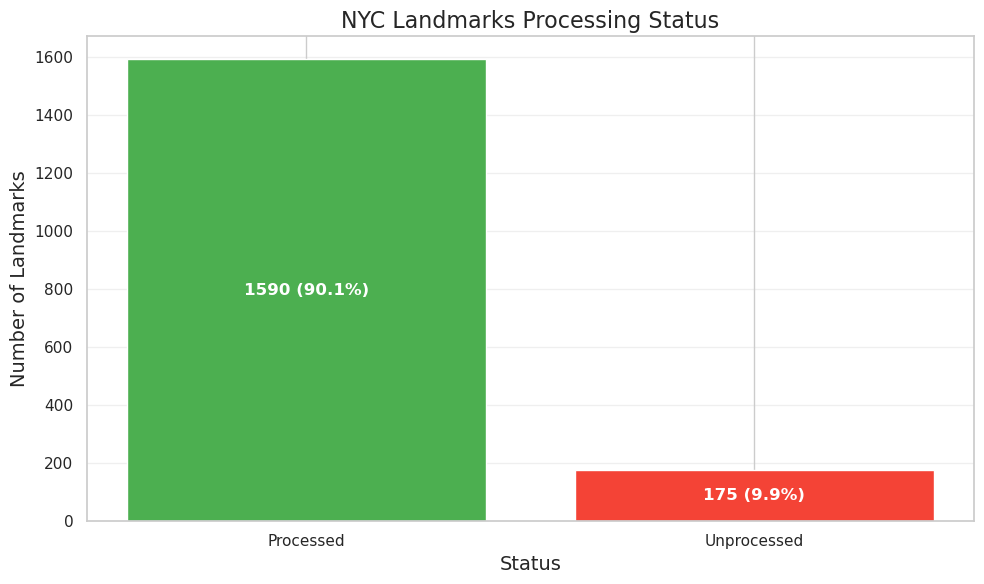

In [11]:
# Create visualization of processing status
plt.figure(figsize=(10, 6))
bars = plt.bar(
    ["Processed", "Unprocessed"],
    [len(processed_landmarks), len(unprocessed_landmarks)],
    color=["#4CAF50", "#F44336"],
)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (
        len(processed_landmarks) / len(all_landmark_ids) * 100
        if i == 0
        else len(unprocessed_landmarks) / len(all_landmark_ids) * 100
    )
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height / 2,
        f"{height} ({percentage:.1f}%)",
        color="white",
        ha="center",
        va="center",
        fontweight="bold",
        fontsize=12,
    )

plt.title("NYC Landmarks Processing Status", fontsize=16)
plt.xlabel("Status", fontsize=14)
plt.ylabel("Number of Landmarks", fontsize=14)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Summary

This notebook has analyzed the processing status of NYC landmark records in the Pinecone vector database by dynamically calculating the required number of pages to process all records.

### Key Improvements

1. **Dynamic Pagination**: Instead of hardcoding the start and end pages, we now:
   - Use the known total record count (1765) from the API
   - Calculate the exact number of pages needed based on page size
   - Ensure all records are processed with no manual adjustments needed
   
2. **Future-Proofing**: If more records are added to the database in the future, the notebook will:
   - Automatically adjust to fetch all records
   - Correctly process new landmarks without code changes
   
3. **Optimized Processing**: The approach is more efficient because it:
   - Fetches exactly the pages needed
   - Doesn't waste time on unnecessary API calls
   - Provides better progress tracking and reporting

These changes make the notebook more robust and maintainable as the dataset grows over time.